In [1]:
# Cell 1 — Setup imports and PYTHONPATH
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

# assume this notebook lives in project/notebooks/
PROJECT_ROOT = Path.cwd().parent
SRC_PATH     = PROJECT_ROOT / 'src'
sys.path.insert(0, str(SRC_PATH))

from utils  import load_image, load_mask, compute_vector_field
from engine import AntEnv
from model  import AntModel


In [2]:
# Cell 2 — Helper to pack one observation into tensors
def pack_inputs(patch_np, memory, device):
    pt = (
        torch.from_numpy(patch_np.astype(np.float32)/255)
             .permute(2,0,1)
             .unsqueeze(0)
             .to(device)
    )
    mem_t = []
    for p_np, a_np in memory:
        p_t = (
            torch.from_numpy(p_np.astype(np.float32)/255)
                 .permute(2,0,1)
                 .to(device)
        )
        a_t = torch.from_numpy(a_np.astype(np.float32)).to(device)
        mem_t.append((p_t, a_t))
    return pt, mem_t


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

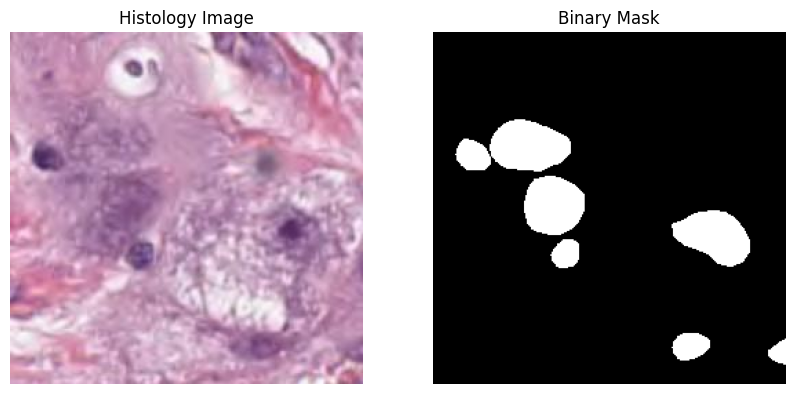

In [3]:
# Cell 3 — Load a single image+mask pair
# Adjust the index or filename as needed:
img_path  = PROJECT_ROOT / 'data' / 'Fold1_jpg' / 'images' / '5.jpg'
mask_path = PROJECT_ROOT / 'data' / 'Fold1_jpg' / 'masks'  / '5.jpg'

img  = load_image(str(img_path))
mask = load_mask(str(mask_path))
vf   = compute_vector_field(mask)

# Display to verify
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Histology Image')
plt.imshow(img); plt.axis('off')

plt.subplot(1,2,2)
plt.title('Binary Mask')
plt.imshow(mask, cmap='gray'); plt.axis('off')


In [5]:
# Cell 4 — Instantiate and load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure n_actions matches how you trained (e.g. 8)
model = AntModel(
    in_channels=3,
    patch_size=(16,16),
    emb_dim=128,
    n_actions=8,
    n_heads=4
).to(device)

# Path to your saved checkpoint:
ckpt = PROJECT_ROOT / 'Agents' / 'agent_0_step14164.pth'
model.load_state_dict(torch.load(ckpt, map_location=device))
model.eval()
print("Loaded model from", ckpt)


Loaded model from /Users/jeremiasz/Desktop/AntNet/Agents/agent_0_step14164.pth


In [6]:
# Cell 4 — Instantiate and load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure n_actions matches how you trained (e.g. 8)
model = AntModel(
    in_channels=3,
    patch_size=(16,16),
    emb_dim=128,
    n_actions=8,
    n_heads=4
).to(device)

# Path to your saved checkpoint:
ckpt = PROJECT_ROOT / 'Agents' / 'agent_0_step14164.pth'
model.load_state_dict(torch.load(ckpt, map_location=device))
model.eval()
print("Loaded model from", ckpt)


Loaded model from /Users/jeremiasz/Desktop/AntNet/Agents/agent_0_step14164.pth


In [7]:
# Cell 5 — Run 50 greedy rollouts from random positions

NUM_AGENTS = 50
T = 500

trajectories = []

for i in range(NUM_AGENTS):
    # fresh env for each agent (random start inside reset)
    env = AntEnv(
        img, mask, vf,
        kernel_size=(16,16),
        memory_len=10,
        max_steps=T,
        boundary='torus'
    )
    obs_patch, mem = env.reset()

    # greedy rollout
    for _ in range(T):
        pt, mem_t = pack_inputs(obs_patch, mem, device)
        with torch.no_grad():
            logits = model(pt, mem_t)
        action = int(logits.argmax(dim=-1).item())
        (obs_patch, mem), _, done, _ = env.step(action)
        if done:
            break

    # store this agent's trajectory
    trajectories.append(env.trajectory)
    print(f'agent {i}')


agent 0
agent 1
agent 2
agent 3
agent 4
agent 5
agent 6
agent 7
agent 8
agent 9
agent 10
agent 11
agent 12
agent 13
agent 14
agent 15
agent 16
agent 17
agent 18
agent 19
agent 20
agent 21
agent 22
agent 23
agent 24
agent 25
agent 26
agent 27
agent 28
agent 29
agent 30
agent 31
agent 32
agent 33
agent 34
agent 35
agent 36
agent 37
agent 38
agent 39
agent 40
agent 41
agent 42
agent 43
agent 44
agent 45
agent 46
agent 47
agent 48
agent 49


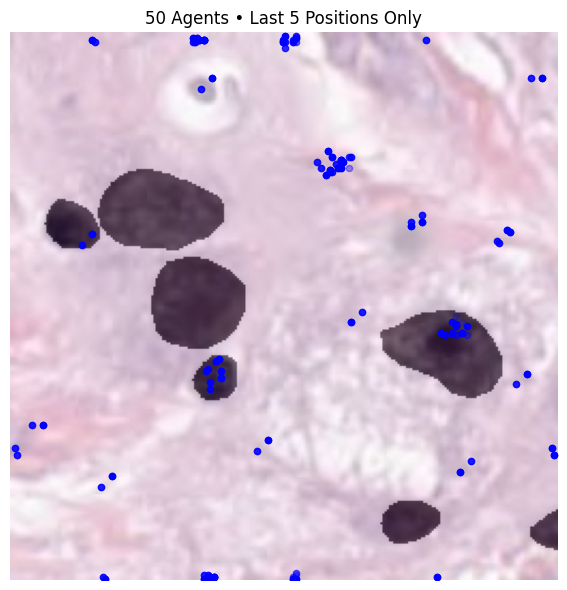

In [8]:
# Cell 6 — Plot only the last 5 positions from each trajectory,
#           with inverted mask overlay (cells stay bright)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(img,  alpha=1.0)

# invert mask so background=1→cover, cells=0→transparent
inv_mask = 1 - mask
ax.imshow(inv_mask, cmap='gray', alpha=0.5)

ax.axis('off')
ax.set_title(f'{NUM_AGENTS} Agents • Last 5 Positions Only')

for traj in trajectories:
    last5 = traj[-5:]
    for i, (x, y) in enumerate(last5):
        alpha = 0.2 + 0.8 * (i / (len(last5) - 1))
        ax.scatter(x, y, s=20, color='blue', alpha=alpha)

plt.tight_layout()
plt.show()

